## Basic Introduction Via Ordinary Differential Equations

This notebook will get you started with DifferentialEquations.jl by introducing you to the functionality for solving ordinary differential equations (ODEs). The corresponding documentation page is the [ODE tutorial](https://docs.sciml.ai/dev/tutorials/ode_example/). While some of the syntax may be different for other types of equations, the same general principles hold in each case. Our goal is to give a gentle and thorough introduction that highlights these principles in a way that will help you generalize what you have learned.

### Background

If you are new to the study of differential equations, it can be helpful to do a quick background read on [the definition of ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation). We define an ordinary differential equation as an equation which describes the way that a variable $u$ changes, that is

$$u' = f(u,p,t)$$

where $p$ are the parameters of the model, $t$ is the time variable, and $f$ is the nonlinear model of how $u$ changes. The initial value problem also includes the information about the starting value:

$$u(t_0) = u_0$$

Together, if you know the starting value and you know how the value will change with time, then you know what the value will be at any time point in the future. This is the intuitive definition of a differential equation.

### First Model: Exponential Growth

Our first model will be the canonical exponential growth model. This model says that the rate of change is proportional to the current value, and is this:

$$u' = au$$

where we have a starting value $u(0)=u_0$. Let's say we put 1 dollar into Bitcoin which is increasing at a rate of $98\%$ per year. Then calling now $t=0$ and measuring time in years, our model is:

$$u' = 0.98u$$

and $u(0) = 1.0$. We encode this into Julia by noticing that, in this setup, we match the general form when

In [1]:
f(u,p,t) = 0.98u

f (generic function with 1 method)

with $u_0 = 1.0$. If we want to solve this model on a time span from `t=0.0` to `t=1.0`, then we define an `ODEProblem` by specifying this function `f`, this initial condition `u0`, and this time span as follows:

In [2]:
using DifferentialEquations
f(u,p,t) = 0.98u
u0 = 1.0
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 1.0

To solve our `ODEProblem` we use the command `solve`.

In [3]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 5-element Vector{Float64}:
 0.0
 0.10042494449239292
 0.35218603951893646
 0.6934436334555072
 1.0
u: 5-element Vector{Float64}:
 1.0
 1.1034222047865465
 1.4121908848175448
 1.9730384867968267
 2.664456142481423

and that's it: we have succesfully solved our first ODE!

#### Analyzing the Solution

Of course, the solution type is not interesting in and of itself. We want to understand the solution! The documentation page which explains in detail the functions for analyzing the solution is the [Solution Handling](https://docs.sciml.ai/dev/basics/solution/) page. Here we will describe some of the basics. You can plot the solution using the plot recipe provided by [Plots.jl](http://docs.juliaplots.org/dev/):

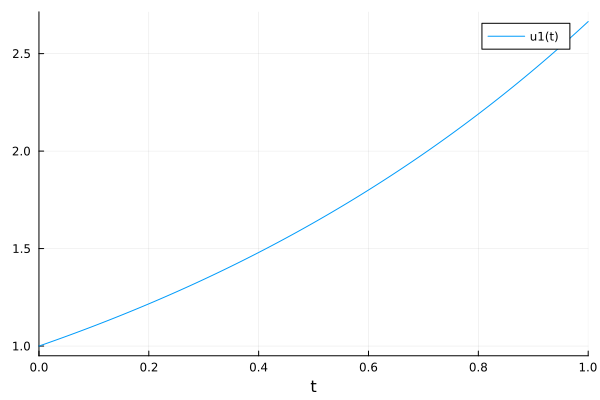

In [4]:
using Plots; gr()
plot(sol)

From the picture we see that the solution is an exponential curve, which matches our intuition. As a plot recipe, we can annotate the result using any of the [Plots.jl attributes](http://docs.juliaplots.org/dev/attributes/). For example:

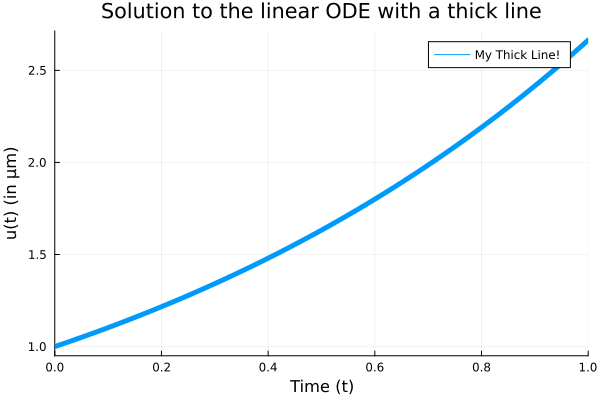

In [5]:
plot(sol,linewidth=5,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t) (in μm)",label="My Thick Line!") # legend=false

Using the mutating `plot!` command we can add other pieces to our plot. For this ODE we know that the true solution is $u(t) = u_0 exp(at)$, so let's add some of the true solution to our plot:

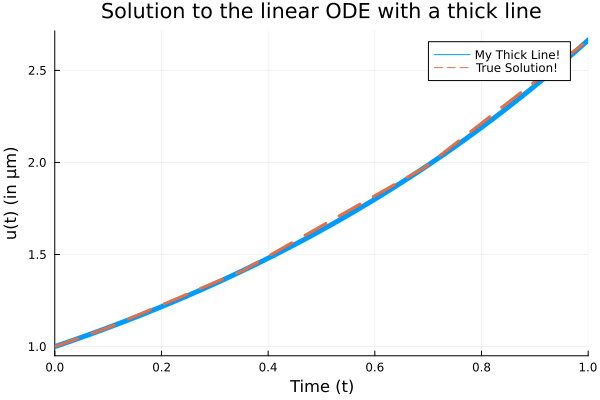

In [6]:
plot!(sol.t, t->1.0*exp(0.98t),lw=3,ls=:dash,label="True Solution!")

In the previous command I demonstrated `sol.t`, which grabs the array of time points that the solution was saved at:

In [7]:
sol.t

5-element Vector{Float64}:
 0.0
 0.10042494449239292
 0.35218603951893646
 0.6934436334555072
 1.0

We can get the array of solution values using `sol.u`:

In [8]:
sol.u

5-element Vector{Float64}:
 1.0
 1.1034222047865465
 1.4121908848175448
 1.9730384867968267
 2.664456142481423

`sol.u[i]` is the value of the solution at time `sol.t[i]`. We can compute arrays of functions of the solution values using standard comprehensions, like:

In [9]:
[t+u for (u,t) in tuples(sol)]

5-element Vector{Float64}:
 1.0
 1.2038471492789395
 1.7643769243364813
 2.6664821202523337
 3.664456142481423

However, one interesting feature is that, by default, the solution is a continuous function. If we check the print out again:

In [10]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 5-element Vector{Float64}:
 0.0
 0.10042494449239292
 0.35218603951893646
 0.6934436334555072
 1.0
u: 5-element Vector{Float64}:
 1.0
 1.1034222047865465
 1.4121908848175448
 1.9730384867968267
 2.664456142481423

you see that it says that the solution has a order changing interpolation. The default algorithm automatically switches between methods in order to handle all types of problems. For non-stiff equations (like the one we are solving), it is a continuous function of 4th order accuracy. We can call the solution as a function of time `sol(t)`. For example, to get the value at `t=0.45`, we can use the command:

In [11]:
sol(0.45)

1.554261048055459

#### Controlling the Solver

DifferentialEquations.jl has a common set of solver controls among its algorithms which can be found [at the Common Solver Options](https://docs.sciml.ai/dev/basics/common_solver_opts/) page. We will detail some of the most widely used options.

The most useful options are the tolerances `abstol` and `reltol`. These tell the internal adaptive time stepping engine how precise of a solution you want. Generally, `reltol` is the relative accuracy while `abstol` is the accuracy when `u` is near zero. These tolerances are local tolerances and thus are not global guarantees. However, a good rule of thumb is that the total solution accuracy is 1-2 digits less than the relative tolerances. Thus for the defaults `abstol=1e-6` and `reltol=1e-3`, you can expect a global accuracy of about 1-2 digits. If we want to get around 6 digits of accuracy, we can use the commands:

In [12]:
sol = solve(prob,abstol=1e-8,reltol=1e-8)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 9-element Vector{Float64}:
 0.0
 0.04127492324135852
 0.1467996608847269
 0.2863160224137678
 0.43819502884198624
 0.6118934817575656
 0.7985671589100553
 0.9993530088359772
 1.0
u: 9-element Vector{Float64}:
 1.0
 1.0412786454705882
 1.1547266712122384
 1.3239102946918078
 1.5363832698868192
 1.8214913928067906
 2.187142321551806
 2.662767375351609
 2.664456241933516

Now we can see no visible difference against the true solution:

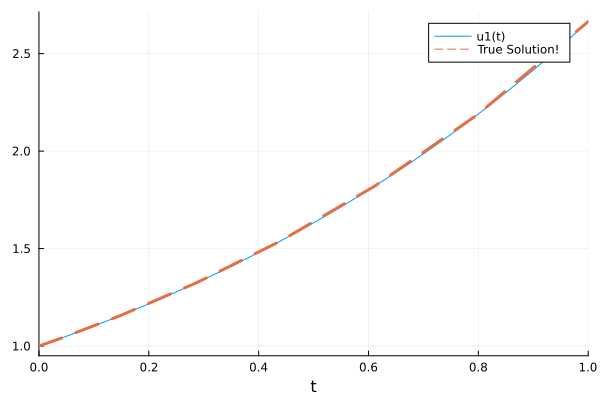

In [13]:
plot(sol)
plot!(sol.t, t->1.0*exp(0.98t),lw=3,ls=:dash,label="True Solution!")

Notice that by decreasing the tolerance, the number of steps the solver had to take was `9` instead of the previous `5`. There is a trade off between accuracy and speed, and it is up to you to determine what is the right balance for your problem.

Another common option is to use `saveat` to make the solver save at specific time points. For example, if we want the solution at an even grid of `t=0.1k` for integers `k`, we would use the command:

In [14]:
sol = solve(prob,saveat=0.1)

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
u: 11-element Vector{Float64}:
 1.0
 1.1029627851292922
 1.2165269512238264
 1.3417838212275421
 1.4799379510586805
 1.6323162070542367
 1.8003833264979394
 1.9857565541587578
 2.1902158127997615
 2.4157257420847684
 2.664456142481423

Notice that when `saveat` is used the continuous output variables are no longer saved and thus `sol(t)`, the interpolation, is only first order. We can save at an uneven grid of points by passing a collection of values to `saveat`. For example:

In [15]:
sol = solve(prob,saveat=[0.2,0.7,0.9])

retcode: Success
Interpolation: 1st order linear
t: 3-element Vector{Float64}:
 0.2
 0.7
 0.9
u: 3-element Vector{Float64}:
 1.2165269512238264
 1.9857565541587578
 2.4157257420847684

If we need to reduce the amount of saving, we can also turn off the continuous output directly via `dense=false`:

In [16]:
sol = solve(prob,dense=false)

retcode: Success
Interpolation: 1st order linear
t: 5-element Vector{Float64}:
 0.0
 0.10042494449239292
 0.35218603951893646
 0.6934436334555072
 1.0
u: 5-element Vector{Float64}:
 1.0
 1.1034222047865465
 1.4121908848175448
 1.9730384867968267
 2.664456142481423

and to turn off all intermediate saving we can use `save_everystep=false`:

In [17]:
sol = solve(prob,save_everystep=false)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 0.0
 1.0
u: 2-element Vector{Float64}:
 1.0
 2.664456142481423

If we want to solve and only save the final value, we can even set `save_start=false`.

In [18]:
sol = solve(prob,save_everystep=false,save_start = false)

retcode: Success
Interpolation: 1st order linear
t: 1-element Vector{Float64}:
 1.0
u: 1-element Vector{Float64}:
 2.664456142481423

Note that similarly on the other side there is `save_end=false`.

More advanced saving behaviors, such as saving functionals of the solution, are handled via the `SavingCallback` in the [Callback Library](https://docs.sciml.ai/dev/features/callback_library/#saving_callback-1) which will be addressed later in the tutorial.

#### Choosing Solver Algorithms

There is no best algorithm for numerically solving a differential equation. When you call `solve(prob)`, DifferentialEquations.jl makes a guess at a good algorithm for your problem, given the properties that you ask for (the tolerances, the saving information, etc.). However, in many cases you may want more direct control. A later notebook will help introduce the various *algorithms* in DifferentialEquations.jl, but for now let's introduce the *syntax*.

The most crucial determining factor in choosing a numerical method is the stiffness of the model. Stiffness is roughly characterized by a Jacobian `f` with large eigenvalues. That's quite mathematical, and we can think of it more intuitively: if you have big numbers in `f` (like parameters of order `1e5`), then it's probably stiff. Or, as the creator of the MATLAB ODE Suite, Lawrence Shampine, likes to define it, if the standard algorithms are slow, then it's stiff. We will go into more depth about diagnosing stiffness in a later tutorial, but for now note that if you believe your model may be stiff, you can hint this to the algorithm chooser via `alg_hints = [:stiff]`.

In [19]:
sol = solve(prob,alg_hints=[:stiff])

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 8-element Vector{Float64}:
 0.0
 0.05653299582822294
 0.17270731152826024
 0.3164602871490142
 0.5057500493966304
 0.7292242404177713
 0.9912979258615463
 1.0
u: 8-element Vector{Float64}:
 1.0
 1.0569657840332976
 1.1844199383303913
 1.3636037723365293
 1.6415400217287892
 2.043449252667953
 2.641826718386915
 2.6644526430975057

Stiff algorithms have to solve implicit equations and linear systems at each step so they should only be used when required.

If we want to choose an algorithm directly, you can pass the algorithm type after the problem as `solve(prob,alg)`. For example, let's solve this problem using the `Tsit5()` algorithm, and just for show let's change the relative tolerance to `1e-6` at the same time:

In [20]:
sol = solve(prob,Tsit5(),reltol=1e-6)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 10-element Vector{Float64}:
 0.0
 0.028970819746309166
 0.10049147151547619
 0.19458908698515082
 0.3071725170882264
 0.43945422364535414
 0.5883435127954693
 0.7524873686506214
 0.929302166760152
 1.0
u: 10-element Vector{Float64}:
 1.0
 1.0287982807225062
 1.1034941463604806
 1.2100931078233779
 1.3512486174374865
 1.5382803540589605
 1.7799346368836084
 2.090571809615733
 2.4861022535689923
 2.6644562434913377

### Systems of ODEs: The Lorenz Equation

Now let's move to a system of ODEs. The [Lorenz equation](https://en.wikipedia.org/wiki/Lorenz_system) is the famous "butterfly attractor" that spawned chaos theory. It is defined by the system of ODEs:

$$
\begin{align}
\frac{dx}{dt} &= \sigma (y - x)\\
\frac{dy}{dt} &= x (\rho - z) -y\\
\frac{dz}{dt} &= xy - \beta z
\end{align}
$$

To define a system of differential equations in DifferentialEquations.jl, we define our `f` as a vector function with a vector initial condition. Thus, for the vector `u = [x,y,z]'`, we have the derivative function:

In [21]:
function lorenz!(du,u,p,t)
    σ,ρ,β = p
    du[1] = σ*(u[2]-u[1])
    du[2] = u[1]*(ρ-u[3]) - u[2]
    du[3] = u[1]*u[2] - β*u[3]
end

lorenz! (generic function with 1 method)

Notice here we used the in-place format which writes the output to the preallocated vector `du`. For systems of equations the in-place format is faster. We use the initial condition $u_0 = [1.0,0.0,0.0]$ as follows:

In [22]:
u0 = [1.0,0.0,0.0]

3-element Vector{Float64}:
 1.0
 0.0
 0.0

Lastly, for this model we made use of the parameters `p`. We need to set this value in the `ODEProblem` as well. For our model we want to solve using the parameters $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$, and thus we build the parameter collection:

In [23]:
p = (10,28,8/3) # we could also make this an array, or any other type!

(10, 28, 2.6666666666666665)

Now we generate the `ODEProblem` type. In this case, since we have parameters, we add the parameter values to the end of the constructor call. Let's solve this on a time span of `t=0` to `t=100`:

In [24]:
tspan = (0.0,100.0)
prob = ODEProblem(lorenz!,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0

Now, just as before, we solve the problem:

In [25]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 1263-element Vector{Float64}:
   0.0
   3.5678604836301404e-5
   0.0003924646531993154
   0.0032624077544510573
   0.009058075635317072
   0.01695646895607931
   0.02768995855685593
   0.04185635042021763
   0.06024041165841079
   0.08368541255159562
   ⋮
  99.30760258626904
  99.39665422328268
  99.49536147459878
  99.58822928767293
  99.68983993598462
  99.77864535713971
  99.85744078539504
  99.93773320913628
 100.0
u: 1263-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [0.9996434557625105, 0.0009988049817849058, 1.781434788799208e-8]
 [0.9961045497425811, 0.010965399721242457, 2.146955365838907e-6]
 [0.9693591634199452, 0.08977060667778931, 0.0001438018342266937]
 [0.9242043615038835, 0.24228912482984957, 0.0010461623302512404]
 [0.8800455868998046, 0.43873645009348244, 0.0034242593451028745]
 [0.8483309847495312, 0.6915629321083602, 0.008487

The same solution handling features apply to this case. Thus `sol.t` stores the time points and `sol.u` is an array storing the solution at the corresponding time points.

However, there are a few extra features which are good to know when dealing with systems of equations. First of all, `sol` also acts like an array. `sol[i]` returns the solution at the `i`th time point.

In [26]:
sol.t[10],sol[10]

(0.08368541255159562, [1.088863826836895, 2.052326595543049, 0.0740257368585531])

Additionally, the solution acts like a matrix where `sol[j,i]` is the value of the `j`th variable at time `i`:

In [27]:
sol[2,10]

2.052326595543049

We can get a real matrix by performing a conversion:

In [28]:
A = Array(sol)

3×1263 Matrix{Float64}:
 1.0  0.999643     0.996105    0.969359     …   8.10973   4.95863   3.80201
 0.0  0.000998805  0.0109654   0.0897706        3.24951   2.19492   2.78702
 0.0  1.78143e-8   2.14696e-6  0.000143802     31.9705   26.9484   23.4206

This is the same as sol, i.e. `sol[i,j] = A[i,j]`, but now it's a true matrix. Plotting will by default show the time series for each variable:

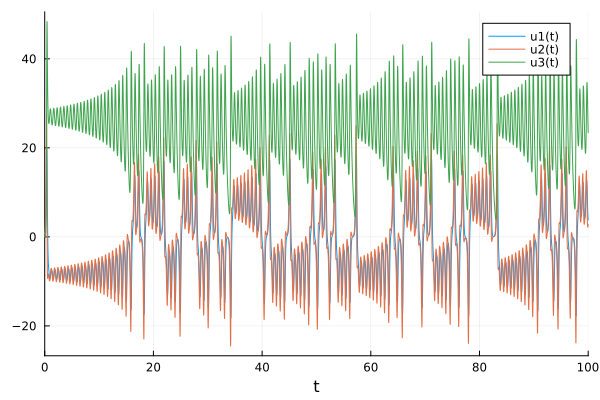

In [29]:
plot(sol)

If we instead want to plot values against each other, we can use the `vars` command. Let's plot variable `1` against variable `2` against variable `3`:

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


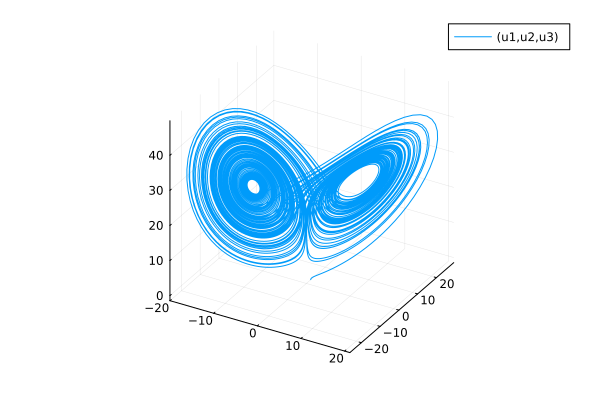

In [30]:
plot(sol,vars=(1,2,3))

This is the classic Lorenz attractor plot, where the `x` axis is `u[1]`, the `y` axis is `u[2]`, and the `z` axis is `u[3]`. Note that the plot recipe by default uses the interpolation, but we can turn this off:

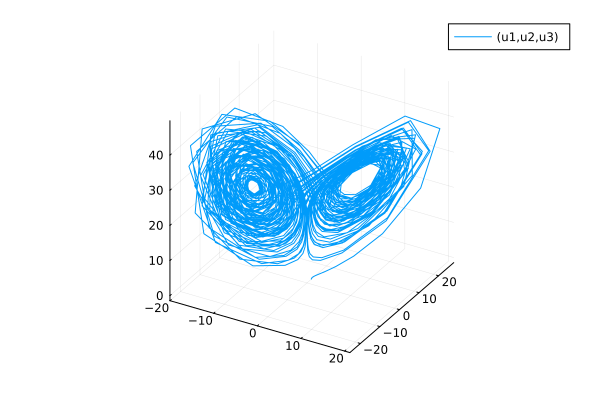

In [31]:
plot(sol,vars=(1,2,3),denseplot=false)

Yikes! This shows how calculating the continuous solution has saved a lot of computational effort by computing only a sparse solution and filling in the values! Note that in vars, `0=time`, and thus we can plot the time series of a single component like:

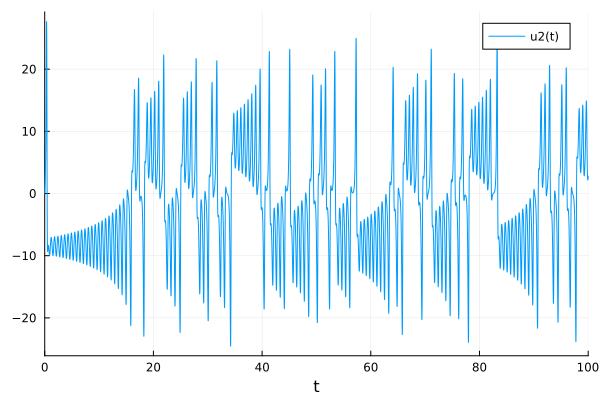

In [32]:
plot(sol,vars=(0,2))

## Internal Types

The last basic user-interface feature to explore is the choice of types. DifferentialEquations.jl respects your input types to determine the internal types that are used. Thus since in the previous cases, when we used `Float64` values for the initial condition, this meant that the internal values would be solved using `Float64`. We made sure that time was specified via `Float64` values, meaning that time steps would utilize 64-bit floats as well. But, by simply changing these types we can change what is used internally.

As a quick example, let's say we want to solve an ODE defined by a matrix. To do this, we can simply use a matrix as input.

In [33]:
A  = [1. 0  0 -5
      4 -2  4 -3
     -4  0  0  1
      5 -2  2  3]
u0 = rand(4,2)
tspan = (0.0,1.0)
f(u,p,t) = A*u
prob = ODEProblem(f,u0,tspan)
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 12-element Vector{Float64}:
 0.0
 0.0014748325012175151
 0.016223157513392667
 0.06481150474751737
 0.13459646511684178
 0.21303967069920945
 0.3120098421311598
 0.42118024248682384
 0.5592895486371798
 0.7166679695726721
 0.8820750524953342
 1.0
u: 12-element Vector{Matrix{Float64}}:
 [0.8850442290342316 0.787753642791901; 0.0015820871526288638 0.8280427208131788; 0.9630511489680469 0.18772328862757415; 0.8813725955916601 0.30529702595265695]
 [0.8797973963278436 0.7866438928735278; 0.008513786579247166 0.8299740055600934; 0.9591550592434505 0.18353347165315712; 0.8946287333808054 0.3105666534553237]
 [0.8215151433357294 0.7733120918072984; 0.07053921326926141 0.84597939598074; 0.9230882168235456 0.14246802423198351; 1.0264754341873967 0.3630844811713657]
 [0.5543200977892522 0.7003459099574089; 0.1829249876345752 0.8567485669165626; 0.8477347359207

There is no real difference from what we did before, but now in this case `u0` is a `4x2` matrix. Because of that, the solution at each time point is matrix:

In [34]:
sol[3]

4×2 Matrix{Float64}:
 0.821515   0.773312
 0.0705392  0.845979
 0.923088   0.142468
 1.02648    0.363084

In DifferentialEquations.jl, you can use any type that defines `+`, `-`, `*`, `/`, and has an appropriate `norm`. For example, if we want arbitrary precision floating point numbers, we can change the input to be a matrix of `BigFloat`:

In [35]:
big_u0 = big.(u0)

4×2 Matrix{BigFloat}:
 0.885044    0.787754
 0.00158209  0.828043
 0.963051    0.187723
 0.881373    0.305297

and we can solve the `ODEProblem` with arbitrary precision numbers by using that initial condition:

In [36]:
prob = ODEProblem(f,big_u0,tspan)
sol = solve(prob)

retcode: Success
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 8-element Vector{Float64}:
 0.0
 0.0014748325012175153
 0.016223157513392667
 0.1437837489298005
 0.3694626056521416
 0.6538221346128746
 0.9680804609561842
 1.0
u: 8-element Vector{Matrix{BigFloat}}:
 [0.88504422903423163315750343826948665082454681396484375 0.78775364279190096539196019875817000865936279296875; 0.0015820871526288637909374301671050488948822021484375 0.82804272081317875642270109892706386744976043701171875; 0.9630511489680468883989306050352752208709716796875 0.1877232886275741474690903487498871982097625732421875; 0.88137259559166014621922613514470867812633514404296875 0.30529702595265695297399588525877334177494049072265625]
 [0.8797973963278436159713413141710528739674444716672445782851238212273432734025335 0.7866438928735277120054358493997428424673952312007203081822331203939467926085612; 0.0085137865792471744600552724880555534401450419500

In [37]:
sol[1,3]

0.8215151433356918362809306231748484791448066794459073200723462547415430982148643

To really make use of this, we would want to change `abstol` and `reltol` to be small! Notice that the type for "time" is different than the type for the dependent variables, and this can be used to optimize the algorithm via keeping multiple precisions. We can convert time to be arbitrary precision as well by defining our time span with `BigFloat` variables:

In [38]:
prob = ODEProblem(f,big_u0,big.(tspan))
sol = solve(prob)

retcode: Success
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 8-element Vector{BigFloat}:
 0.0
 0.001474832501217515180126143582115887191054687270315982906018164645368307325188242
 0.01622315751339266698138757940327475910160155997347581196619981109905138057707057
 0.1437837489298004892566058172029628851851244657976756206181791432787436085711167
 0.3694626056521416225038653611204333119636117193289358313183181377037357336942142
 0.6538221346128746520616048705920338619932255086623673917832528878855933479521182
 0.9680804609561842500787574462153619615152509127710459183893993105625942186362797
 1.0
u: 8-element Vector{Matrix{BigFloat}}:
 [0.88504422903423163315750343826948665082454681396484375 0.78775364279190096539196019875817000865936279296875; 0.0015820871526288637909374301671050488948822021484375 0.82804272081317875642270109892706386744976043701171875; 0.9630511489680468883989306050352752208709716796875 0.18772328

Let's end by showing a more complicated use of types. For small arrays, it's usually faster to do operations on static arrays via the package [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl). The syntax is similar to that of normal arrays, but for these special arrays we utilize the `@SMatrix` macro to indicate we want to create a static array.

In [40]:
using StaticArrays
A  = @SMatrix [ 1.0  0.0 0.0 -5.0
                4.0 -2.0 4.0 -3.0
               -4.0  0.0 0.0  1.0
                5.0 -2.0 2.0  3.0]
u0 = @SMatrix rand(4,2)
tspan = (0.0,1.0)
f(u,p,t) = A*u
prob = ODEProblem(f,u0,tspan)
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 11-element Vector{Float64}:
 0.0
 0.021145810483529006
 0.07292731478562677
 0.14408050025551664
 0.23357663607468893
 0.3410881238967623
 0.468655039125234
 0.6110850669256631
 0.7605616508980506
 0.9214123288002289
 1.0
u: 11-element Vector{SMatrix{4, 2, Float64, 8}}:
 [0.01443065838553459 0.5407034471900302; 0.036241061585200574 0.4538839578517486; 0.2550884205467565 0.9347362852324205; 0.40822588234526636 0.94691443000352]
 [-0.030803597176970208 0.44381993788505514; 0.02909421960672736 0.48935450966928384; 0.2647613378087272 0.9144480011347618; 0.44402119574281135 1.0825456214587574]
 [-0.16114544739929515 0.13790428864963128; -0.008014788297901814 0.4947836583651678; 0.3092675505610984 0.9168113188043454; 0.5231922433841182 1.3949883943985253]
 [-0.3822886841152793 -0.4359236857407944; -0.09557276901952245 0.33474367824488793; 0.425931348175556

In [41]:
sol[3]

4×2 SMatrix{4, 2, Float64, 8} with indices SOneTo(4)×SOneTo(2):
 -0.161145    0.137904
 -0.00801479  0.494784
  0.309268    0.916811
  0.523192    1.39499

## Conclusion

These are the basic controls in DifferentialEquations.jl. All equations are defined via a problem type, and the `solve` command is used with an algorithm choice (or the default) to get a solution. Every solution acts the same, like an array `sol[i]` with `sol.t[i]`, and also like a continuous function `sol(t)` with a nice plot command `plot(sol)`. The Common Solver Options can be used to control the solver for any equation type. Lastly, the types used in the numerical solving are determined by the input types, and this can be used to solve with arbitrary precision and add additional optimizations (this can be used to solve via GPUs for example!). While this was shown on ODEs, these techniques generalize to other types of equations as well.

In [42]:
using SciMLTutorials
SciMLTutorials.tutorial_footer(WEAVE_ARGS[:folder],WEAVE_ARGS[:file])

UndefVarError: UndefVarError: WEAVE_ARGS not defined